In [3]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt

import datetime as dt
import tensorflow as tf

from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation,Dropout,Flatten,Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Conv2D

devices = tf.config.list_physical_devices('GPU')
tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(devices[0], 'GPU')

def build_generator():
    noise_shape = (z_dim, )

    model = Sequential(name='Generator')

    model.add(Dense(256, input_shape=noise_shape, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    return model

def build_discriminator():
    img_shape = (img_rows, img_cols, channels)

    model = Sequential(name='Discriminator')

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    return model


def build_combined():
    discriminator.trainable = False
    model = Sequential([generator, discriminator], name='Combined')
    model.summary()

    return model

def save_imgs(log_path, epoch):
    r, c = 5, 5

    noise = np.random.normal(0, 1, (r * c, z_dim))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("{}/{}.png".format(log_path, epoch))
    plt.show()
    plt.close()

def train(epochs, batch_size=512, save_interval=1):
    # データセットをダウンロードして読み込む
    (X_train, _),(_, _) = mnist.load_data()
    
    # -1 ～ 1の範囲にする
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    X_train = np.expand_dims(X_train, axis = 3)

    half_batch = int(batch_size / 2)
    num_batches = int(X_train.shape[0] / half_batch)
    print("Number of Batches : ", num_batches)

    log_path = 'log/{}/images'.format(dt.datetime.now().strftime("%Y-%m-%d_%H%M%S"))
    os.makedirs(log_path, exist_ok=True)
    
    for epoch in range(epochs):
        for iteration in range(num_batches):
            # NoiseからGeneratorで生成
            noise = np.random.normal(0, 1, (half_batch, z_dim))
            gen_imgs = generator.predict(noise)

            # データセットから画像をピックアップ
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            # それぞれのデータでDiscriminatorを学習
            d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

            # DiscriminatorのLossを算出
            d_loss = np.add(d_loss_real, d_loss_fake) / 2

            # ノイズ生成
            noise = np.random.normal(0, 1, (batch_size, z_dim))

            # 騙すことが正解になる目的変数
            valid_y = np.array([1] * batch_size)

            #Generatorを学習
            g_loss = combined_model.train_on_batch(noise, valid_y)

        if epoch % save_interval == 0:
            # 生成画像の表示と保存
            print ("epoch:%d, iter:%d,  [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, iteration, d_loss[0], 100*d_loss[1], g_loss))
            save_imgs(log_path, epoch)

In [4]:
# 入力画像のサイズ
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

# ノイズの次元数
z_dim = 20

# 最適化関数
optimizer = Adam(lr=0.0001, beta_1=0.5)

# Discriminator
discriminator = build_discriminator()
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Generator
generator = build_generator()

# ネットワーク作成
combined_model = build_combined()
combined_model.compile(loss="binary_crossentropy", optimizer=optimizer)

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               5376      
____________________________

Number of Batches :  234
epoch:0, iter:233,  [D loss: 0.685211, acc.: 45.51%] [G loss: 0.981696]


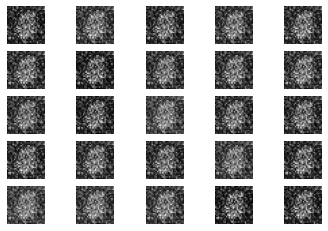

epoch:1, iter:233,  [D loss: 0.578410, acc.: 56.25%] [G loss: 1.152460]


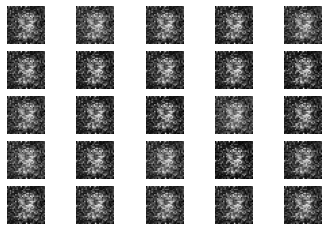

epoch:2, iter:233,  [D loss: 0.461026, acc.: 95.12%] [G loss: 1.481172]


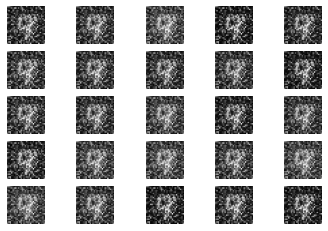

epoch:3, iter:233,  [D loss: 0.374812, acc.: 94.34%] [G loss: 1.708308]


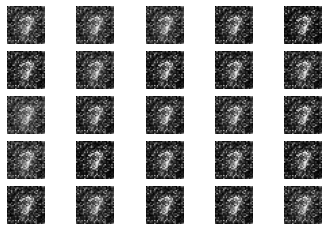

epoch:4, iter:233,  [D loss: 0.414792, acc.: 91.60%] [G loss: 1.887176]


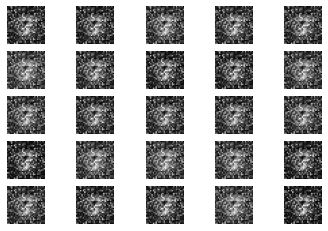

epoch:5, iter:233,  [D loss: 0.261309, acc.: 93.95%] [G loss: 2.218377]


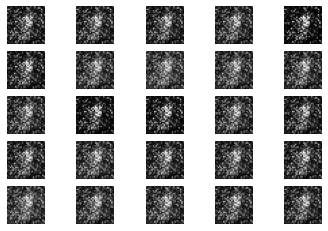

epoch:6, iter:233,  [D loss: 0.232767, acc.: 95.31%] [G loss: 3.151444]


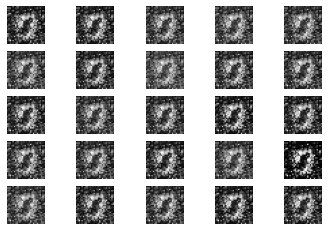

epoch:7, iter:233,  [D loss: 0.193267, acc.: 95.90%] [G loss: 2.654038]


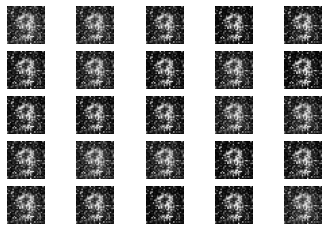

epoch:8, iter:233,  [D loss: 0.148003, acc.: 96.29%] [G loss: 3.114227]


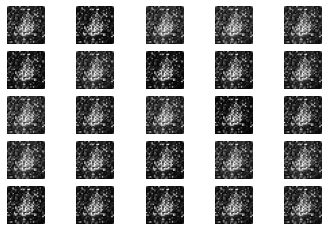

epoch:9, iter:233,  [D loss: 0.144760, acc.: 97.27%] [G loss: 3.347391]


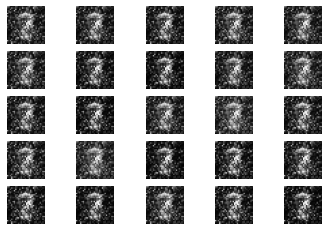

epoch:10, iter:233,  [D loss: 0.118105, acc.: 97.46%] [G loss: 3.781527]


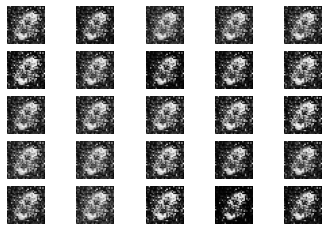

epoch:11, iter:233,  [D loss: 0.191328, acc.: 93.75%] [G loss: 3.630059]


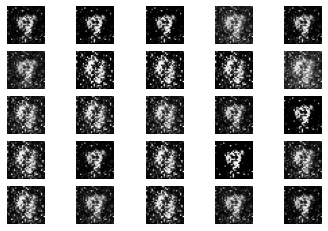

epoch:12, iter:233,  [D loss: 0.172359, acc.: 93.55%] [G loss: 3.531614]


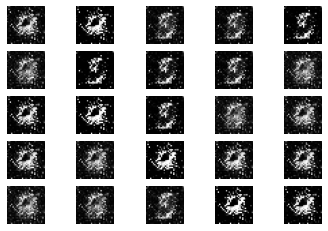

epoch:13, iter:233,  [D loss: 0.096094, acc.: 96.68%] [G loss: 4.177328]


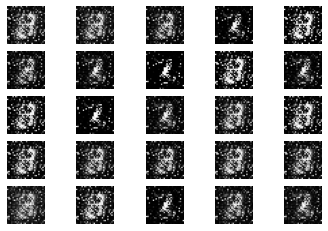

epoch:14, iter:233,  [D loss: 0.065382, acc.: 99.02%] [G loss: 4.135747]


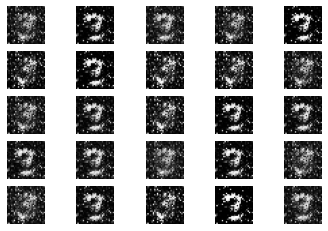

epoch:15, iter:233,  [D loss: 0.188761, acc.: 97.85%] [G loss: 6.399596]


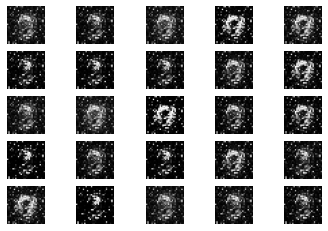

epoch:16, iter:233,  [D loss: 0.110851, acc.: 98.44%] [G loss: 4.610174]


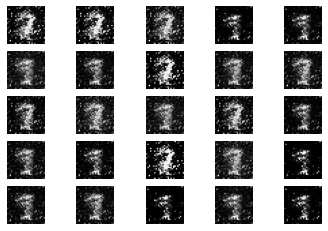

epoch:17, iter:233,  [D loss: 0.145201, acc.: 97.07%] [G loss: 3.824209]


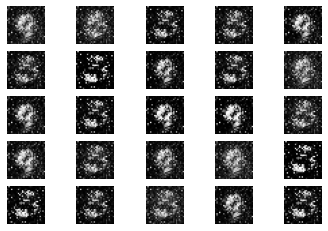

epoch:18, iter:233,  [D loss: 0.112192, acc.: 97.07%] [G loss: 4.299102]


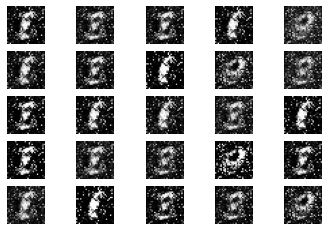

epoch:19, iter:233,  [D loss: 0.227369, acc.: 95.31%] [G loss: 4.706061]


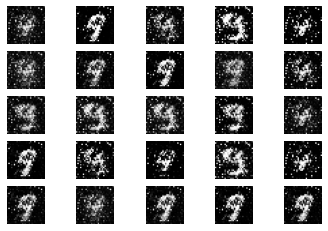

epoch:20, iter:233,  [D loss: 0.350187, acc.: 83.40%] [G loss: 5.723909]


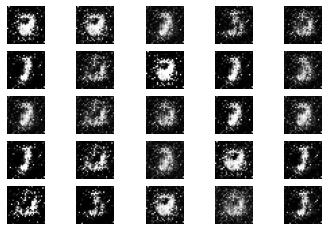

epoch:21, iter:233,  [D loss: 0.225433, acc.: 94.14%] [G loss: 4.511610]


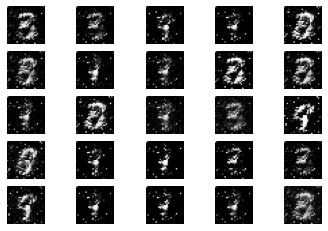

epoch:22, iter:233,  [D loss: 0.130726, acc.: 97.27%] [G loss: 4.073760]


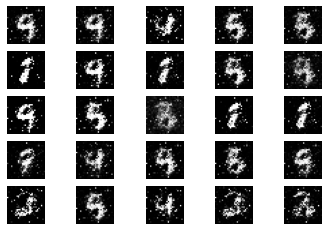

epoch:23, iter:233,  [D loss: 0.213619, acc.: 92.97%] [G loss: 3.560886]


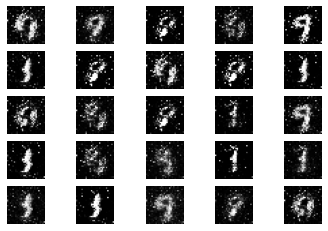

epoch:24, iter:233,  [D loss: 0.251604, acc.: 92.19%] [G loss: 3.755737]


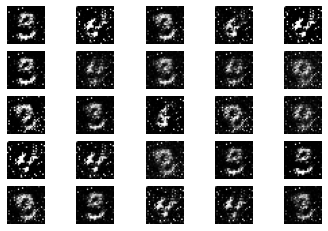

epoch:25, iter:233,  [D loss: 0.304202, acc.: 92.19%] [G loss: 4.309392]


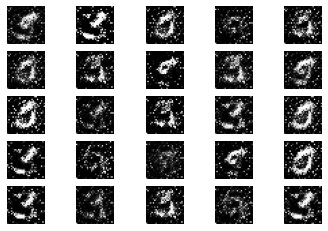

epoch:26, iter:233,  [D loss: 0.289852, acc.: 89.65%] [G loss: 4.433830]


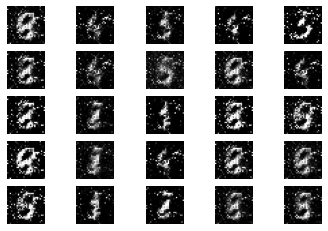

epoch:27, iter:233,  [D loss: 0.266078, acc.: 91.21%] [G loss: 3.899757]


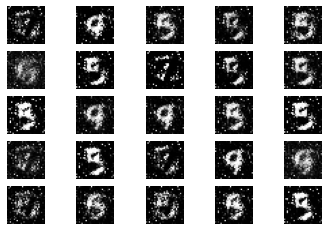

epoch:28, iter:233,  [D loss: 0.374050, acc.: 86.52%] [G loss: 3.486584]


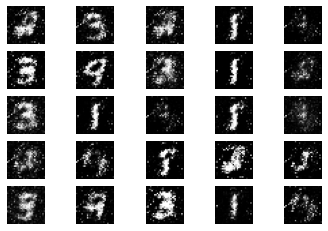

epoch:29, iter:233,  [D loss: 0.288932, acc.: 91.21%] [G loss: 3.633903]


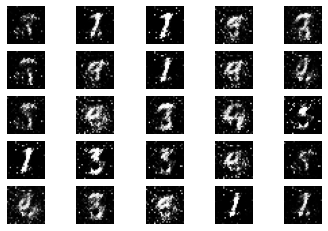

epoch:30, iter:233,  [D loss: 0.304510, acc.: 89.65%] [G loss: 3.053286]


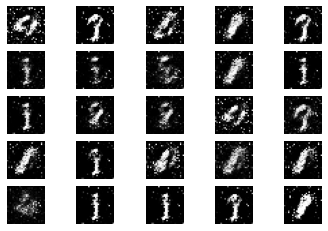

epoch:31, iter:233,  [D loss: 0.289606, acc.: 90.82%] [G loss: 3.085963]


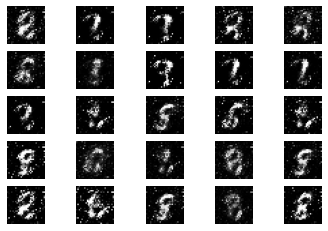

epoch:32, iter:233,  [D loss: 0.280961, acc.: 89.65%] [G loss: 2.907866]


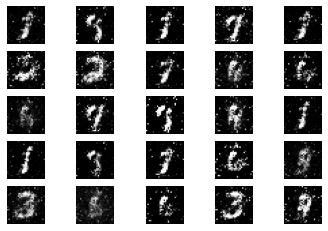

epoch:33, iter:233,  [D loss: 0.509180, acc.: 80.47%] [G loss: 3.044345]


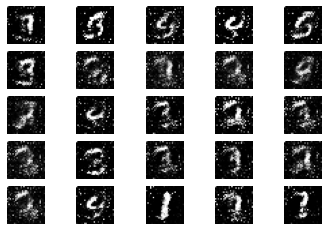

epoch:34, iter:233,  [D loss: 0.378291, acc.: 85.74%] [G loss: 2.722392]


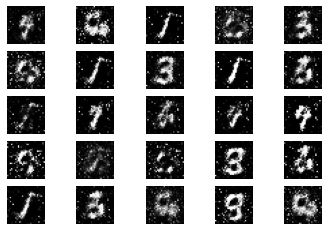

epoch:35, iter:233,  [D loss: 0.300787, acc.: 89.65%] [G loss: 2.892316]


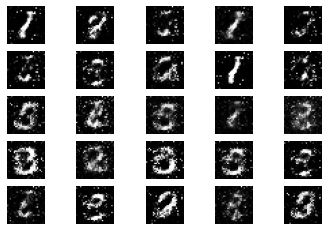

epoch:36, iter:233,  [D loss: 0.460037, acc.: 83.20%] [G loss: 2.570580]


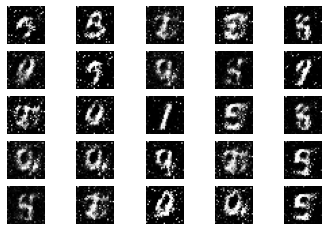

epoch:37, iter:233,  [D loss: 0.335401, acc.: 87.70%] [G loss: 2.460430]


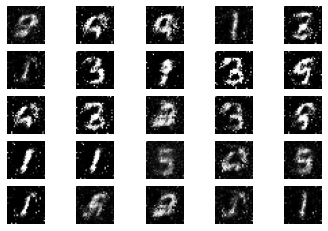

epoch:38, iter:233,  [D loss: 0.541040, acc.: 74.41%] [G loss: 2.010890]


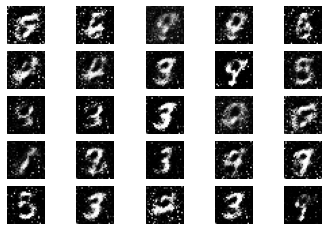

epoch:39, iter:233,  [D loss: 0.516121, acc.: 77.34%] [G loss: 2.059824]


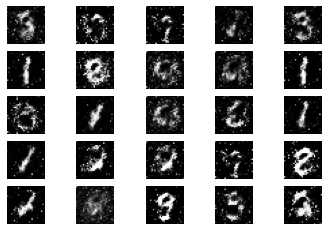

epoch:40, iter:233,  [D loss: 0.441834, acc.: 80.47%] [G loss: 2.177562]


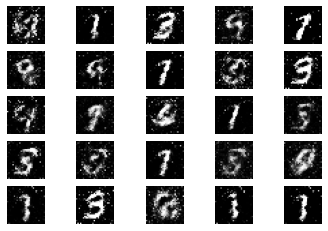

epoch:41, iter:233,  [D loss: 0.546920, acc.: 73.44%] [G loss: 1.838858]


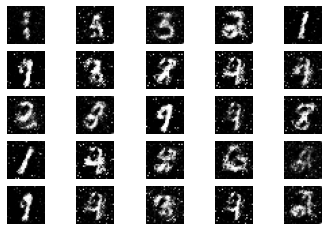

epoch:42, iter:233,  [D loss: 0.485969, acc.: 75.20%] [G loss: 1.754508]


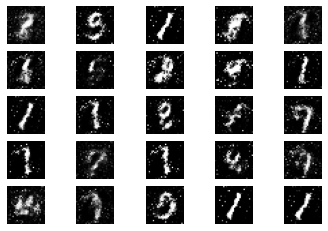

epoch:43, iter:233,  [D loss: 0.485877, acc.: 76.37%] [G loss: 1.733197]


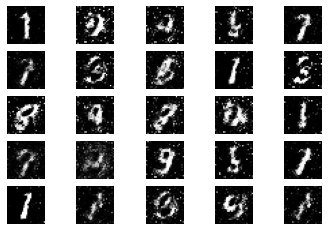

epoch:44, iter:233,  [D loss: 0.532853, acc.: 74.61%] [G loss: 1.732814]


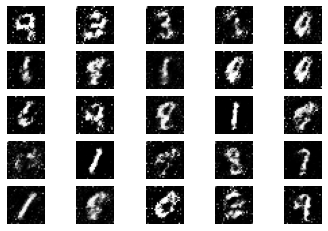

epoch:45, iter:233,  [D loss: 0.447261, acc.: 84.38%] [G loss: 1.685391]


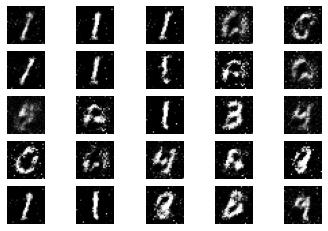

epoch:46, iter:233,  [D loss: 0.492091, acc.: 75.39%] [G loss: 1.643239]


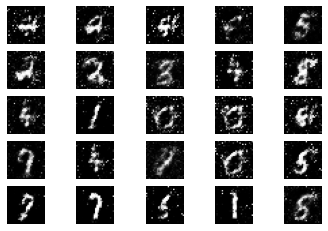

epoch:47, iter:233,  [D loss: 0.535315, acc.: 76.56%] [G loss: 1.613118]


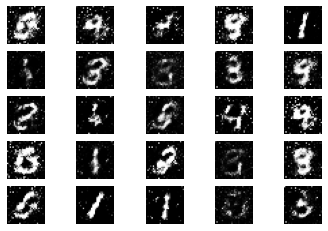

epoch:48, iter:233,  [D loss: 0.510854, acc.: 75.78%] [G loss: 1.530946]


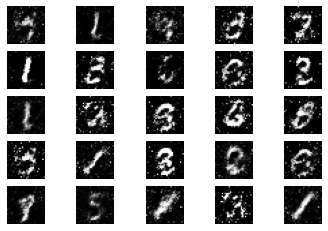

epoch:49, iter:233,  [D loss: 0.499547, acc.: 76.56%] [G loss: 1.572529]


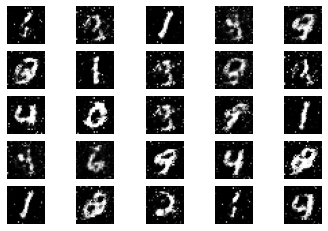

epoch:50, iter:233,  [D loss: 0.604438, acc.: 69.34%] [G loss: 1.358228]


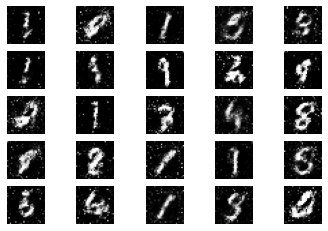

epoch:51, iter:233,  [D loss: 0.553975, acc.: 72.66%] [G loss: 1.420752]


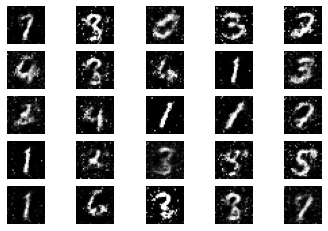

epoch:52, iter:233,  [D loss: 0.521771, acc.: 74.61%] [G loss: 1.446600]


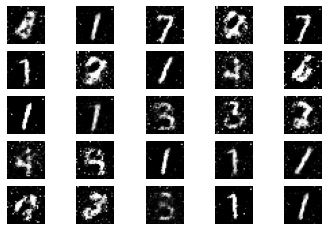

epoch:53, iter:233,  [D loss: 0.548338, acc.: 71.88%] [G loss: 1.383981]


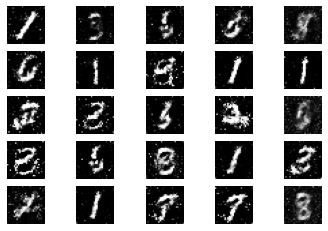

epoch:54, iter:233,  [D loss: 0.585559, acc.: 72.66%] [G loss: 1.379609]


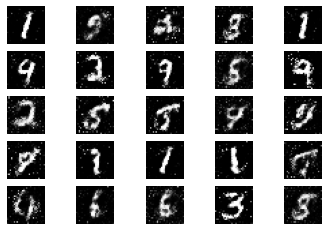

epoch:55, iter:233,  [D loss: 0.484740, acc.: 78.32%] [G loss: 1.326212]


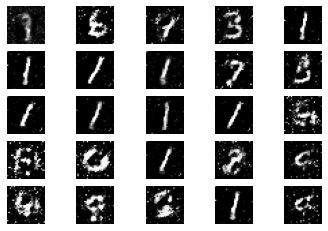

epoch:56, iter:233,  [D loss: 0.563004, acc.: 69.73%] [G loss: 1.442025]


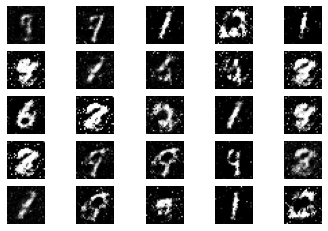

epoch:57, iter:233,  [D loss: 0.524048, acc.: 71.88%] [G loss: 1.346144]


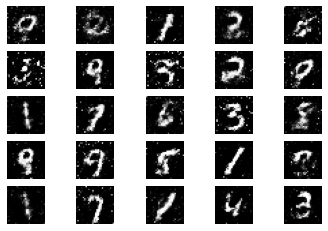

epoch:58, iter:233,  [D loss: 0.520129, acc.: 77.93%] [G loss: 1.359392]


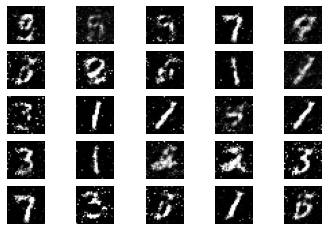

epoch:59, iter:233,  [D loss: 0.533509, acc.: 74.61%] [G loss: 1.474117]


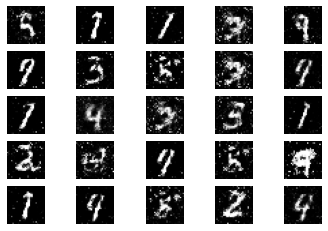

epoch:60, iter:233,  [D loss: 0.582520, acc.: 69.92%] [G loss: 1.284499]


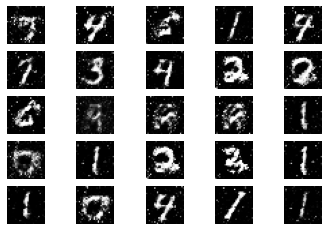

epoch:61, iter:233,  [D loss: 0.611533, acc.: 66.41%] [G loss: 1.188446]


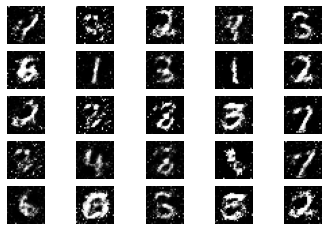

epoch:62, iter:233,  [D loss: 0.537712, acc.: 74.02%] [G loss: 1.395678]


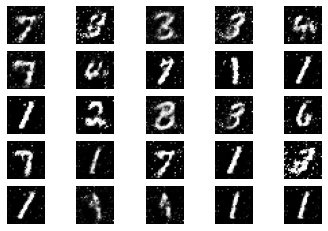

epoch:63, iter:233,  [D loss: 0.520076, acc.: 75.39%] [G loss: 1.366813]


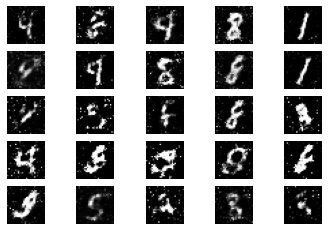

epoch:64, iter:233,  [D loss: 0.536893, acc.: 73.83%] [G loss: 1.373880]


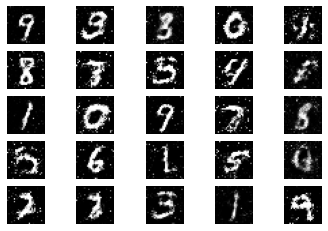

epoch:65, iter:233,  [D loss: 0.529238, acc.: 75.00%] [G loss: 1.339320]


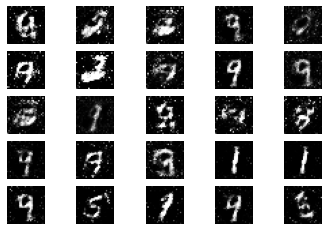

epoch:66, iter:233,  [D loss: 0.575155, acc.: 69.73%] [G loss: 1.271530]


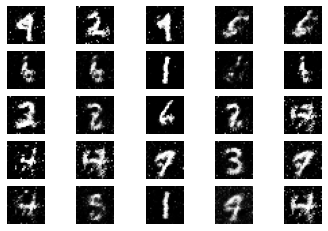

epoch:67, iter:233,  [D loss: 0.570406, acc.: 69.34%] [G loss: 1.215214]


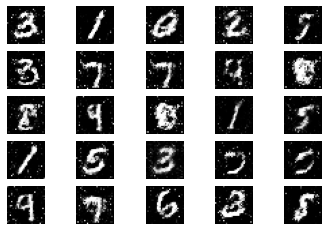

epoch:68, iter:233,  [D loss: 0.595536, acc.: 70.12%] [G loss: 1.198585]


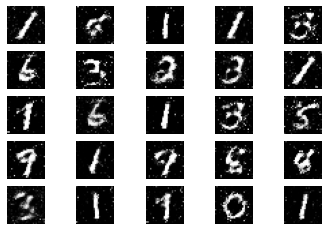

epoch:69, iter:233,  [D loss: 0.616997, acc.: 66.21%] [G loss: 1.180085]


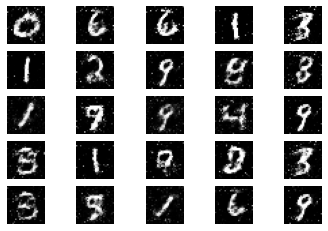

epoch:70, iter:233,  [D loss: 0.601971, acc.: 67.58%] [G loss: 1.198633]


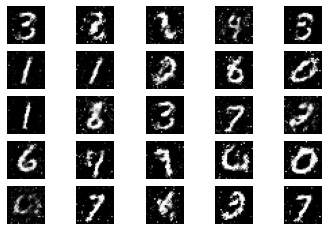

epoch:71, iter:233,  [D loss: 0.589041, acc.: 66.99%] [G loss: 1.173577]


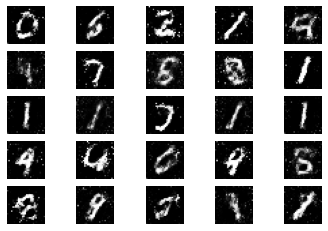

epoch:72, iter:233,  [D loss: 0.587440, acc.: 70.51%] [G loss: 1.216138]


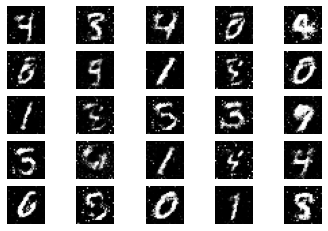

epoch:73, iter:233,  [D loss: 0.512961, acc.: 75.39%] [G loss: 1.378635]


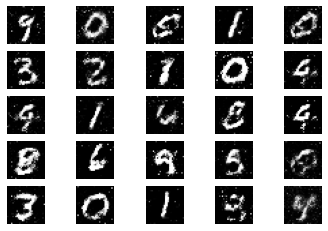

epoch:74, iter:233,  [D loss: 0.607215, acc.: 67.38%] [G loss: 1.223475]


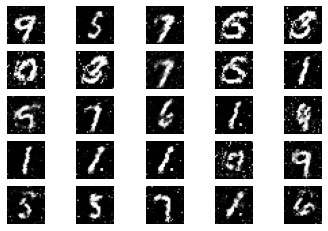

epoch:75, iter:233,  [D loss: 0.588067, acc.: 71.09%] [G loss: 1.261616]


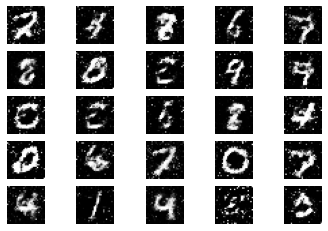

epoch:76, iter:233,  [D loss: 0.565217, acc.: 73.05%] [G loss: 1.261140]


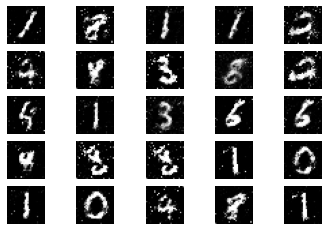

epoch:77, iter:233,  [D loss: 0.547132, acc.: 71.88%] [G loss: 1.309816]


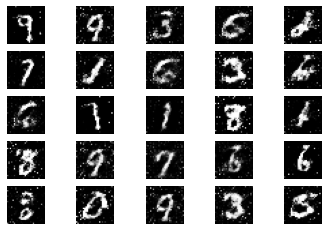

epoch:78, iter:233,  [D loss: 0.574085, acc.: 71.29%] [G loss: 1.273043]


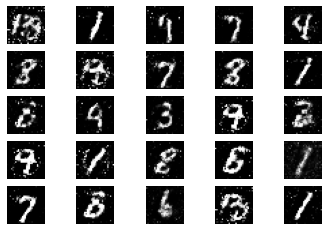

epoch:79, iter:233,  [D loss: 0.618238, acc.: 63.87%] [G loss: 1.188524]


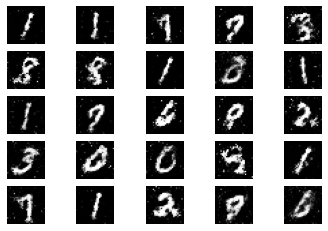

epoch:80, iter:233,  [D loss: 0.457810, acc.: 80.86%] [G loss: 1.347039]


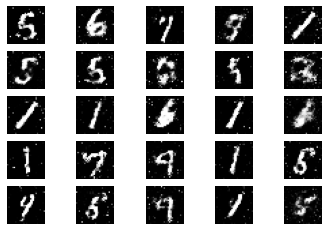

epoch:81, iter:233,  [D loss: 0.566051, acc.: 72.07%] [G loss: 1.282964]


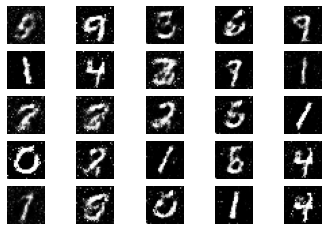

epoch:82, iter:233,  [D loss: 0.631524, acc.: 64.65%] [G loss: 1.219155]


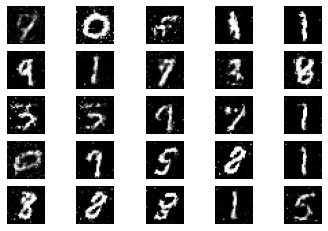

epoch:83, iter:233,  [D loss: 0.586666, acc.: 66.02%] [G loss: 1.236082]


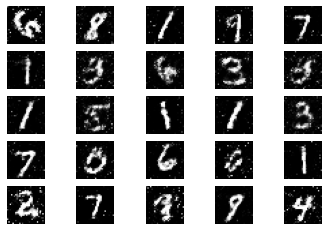

epoch:84, iter:233,  [D loss: 0.545660, acc.: 74.02%] [G loss: 1.245692]


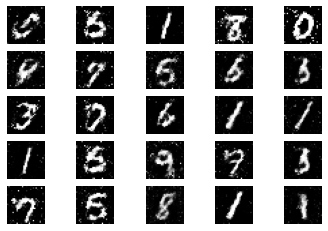

epoch:85, iter:233,  [D loss: 0.558123, acc.: 72.27%] [G loss: 1.210300]


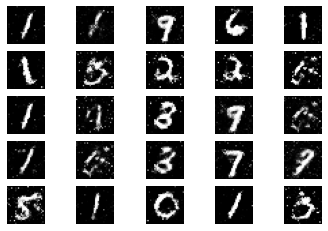

epoch:86, iter:233,  [D loss: 0.554645, acc.: 72.27%] [G loss: 1.212422]


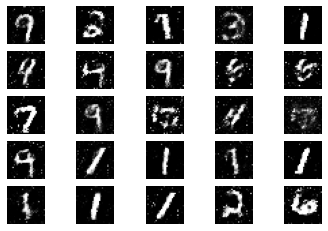

epoch:87, iter:233,  [D loss: 0.574840, acc.: 69.73%] [G loss: 1.264456]


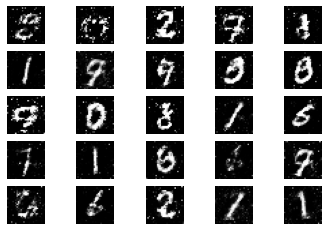

epoch:88, iter:233,  [D loss: 0.510410, acc.: 76.95%] [G loss: 1.176525]


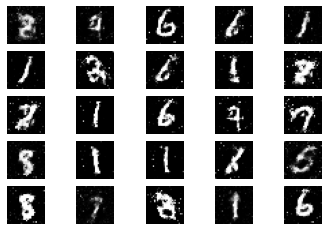

epoch:89, iter:233,  [D loss: 0.626197, acc.: 64.06%] [G loss: 1.282897]


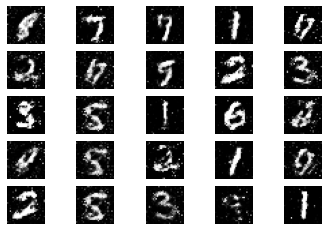

epoch:90, iter:233,  [D loss: 0.557888, acc.: 73.24%] [G loss: 1.227378]


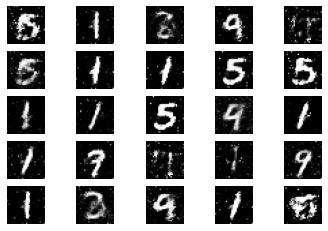

epoch:91, iter:233,  [D loss: 0.572459, acc.: 68.95%] [G loss: 1.204567]


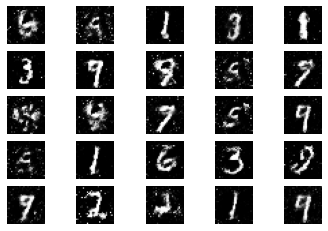

epoch:92, iter:233,  [D loss: 0.507583, acc.: 76.56%] [G loss: 1.323971]


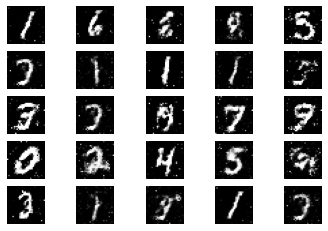

epoch:93, iter:233,  [D loss: 0.592409, acc.: 69.14%] [G loss: 1.197583]


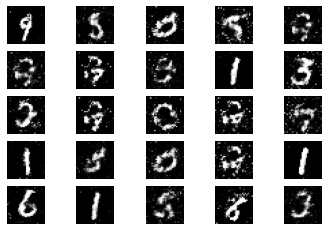

epoch:94, iter:233,  [D loss: 0.497704, acc.: 77.93%] [G loss: 1.356295]


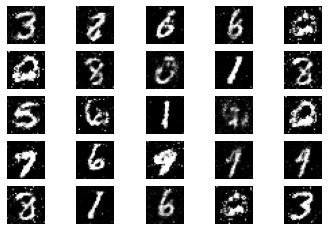

epoch:95, iter:233,  [D loss: 0.529131, acc.: 72.66%] [G loss: 1.223364]


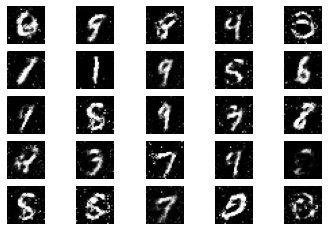

epoch:96, iter:233,  [D loss: 0.510314, acc.: 77.73%] [G loss: 1.278002]


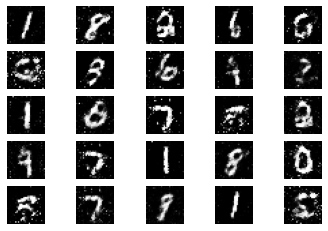

epoch:97, iter:233,  [D loss: 0.537820, acc.: 75.00%] [G loss: 1.236096]


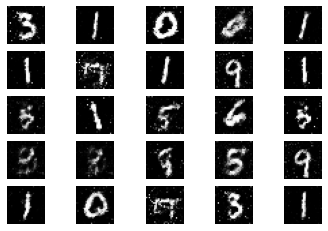

epoch:98, iter:233,  [D loss: 0.559543, acc.: 71.88%] [G loss: 1.258699]


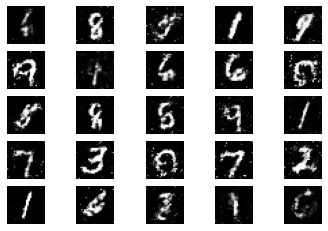

epoch:99, iter:233,  [D loss: 0.536104, acc.: 72.07%] [G loss: 1.229074]


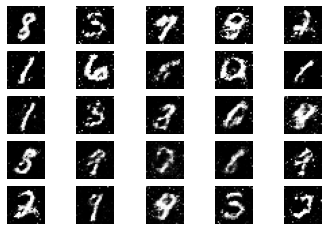

In [5]:
# 学習
train(epochs=100)